In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [3]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

In [4]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)
ExpSinelbounds = (1e-1, 10.0)
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-2, 20)
nu = 1.75
alpha = 1
periodicity = 2
periodictybounds = (1, 20)
gamma = 1
noiselvlinit = 1
noiselvlboundsinit = (1e-4, 20)
noiselvlwerror = E.mean()
noiselvlboundswerror =(E.mean() - 2*1e-1, E.mean() + 2*1e-1)
noiselvlboundserrorminmax = (E.min(),E.max())

noiselvls = [noiselvlinit, noiselvlwerror,noiselvlwerror]
noiselvlbounds = [noiselvlboundsinit, noiselvlboundswerror,noiselvlboundserrorminmax]

fits =[]
stds = []
rmse = []
mae = []
r2 = []
adjustedr2 = []
fom = []
pearsoncoeff = []

for noiselvl, noiselvlbounds in tqdm(list(zip(noiselvls, noiselvlbounds)),total = len(noiselvls)):
    noiselvl = noiselvl
    noiselvlbounds = noiselvlbounds

    Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu) + WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle) + WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=ExpSinelbounds,periodicity_bounds=periodictybounds)+ WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, metric='laplacian')+ WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)+ WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    kernel_list = [Radkernel, ExpSinekernel, Laplacekernel, RBFkernel,Matkernel]
    kernel_names = ['Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matern']
    dimensionnames = [['sigma','alpha','l','noiselvl'],['sigma','l','periodicity','noiselvl'],['sigma','gamma','noiselvl'],['sigma','l1','l2','l3','l4','noiselvl'],['sigma','l1','l2','l3','l4','noiselvl']]
    
    for kernel, kernel_name, dimensionname in zip(kernel_list, kernel_names, dimensionnames):
        gpr = GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=2,random_state=42)
        gpr.fit(X_train, D_train)
        print(f"Fitted Kernel: {gpr.kernel_}")
        Dfit, Dstd = gpr.predict(X1, return_std=True)
        Dtestfit,Dteststd = gpr.predict(X1_test, return_std=True)
        pointwiseparams = np.exp(gpr.kernel_.theta)
        fits.append(Dfit)
        stds.append(Dstd) 
        rmse.append(np.sqrt(mean_squared_error(D1_test, Dtestfit)))
        mae.append(mean_absolute_error(D1_test, Dtestfit))
        r2.append(r2_score(D1_test, Dtestfit))
        adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
        fom.append(np.mean(np.abs(D1_test - Dtestfit)/Dteststd))
        corr, p_value = pearsonr(D1_test.ravel(), Dtestfit.ravel())
        pearsoncoeff.append(corr)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitted Kernel: 1.31**2 * RationalQuadratic(alpha=1.76, length_scale=0.804) + WhiteKernel(noise_level=0.127)
Fitted Kernel: 0.181**2 * ExpSineSquared(length_scale=0.205, periodicity=1.19) + WhiteKernel(noise_level=3.91)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 2.83**2 * PairwiseKernel(gamma=0.3382540076682047, metric=laplacian) + WhiteKernel(noise_level=0.0001)
Fitted Kernel: 0.868**2 * RBF(length_scale=[0.111, 0.11, 1.06, 1.79]) + WhiteKernel(noise_level=0.00798)


 33%|███▎      | 1/3 [01:47<03:34, 107.03s/it]

Fitted Kernel: 1.01**2 * Matern(length_scale=[0.237, 0.205, 1.21, 3.35], nu=1.75) + WhiteKernel(noise_level=0.00744)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 1.25**2 * RationalQuadratic(alpha=5.88, length_scale=0.961) + WhiteKernel(noise_level=0.443)
Fitted Kernel: 0.415**2 * ExpSineSquared(length_scale=7.97, periodicity=8.96) + WhiteKernel(noise_level=0.651)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 0.936**2 * PairwiseKernel(gamma=0.3043801537672111, metric=laplacian) + WhiteKernel(noise_level=0.443)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 0.83**2 * RBF(length_scale=[0.0001, 0.857, 0.936, 10]) + WhiteKernel(noise_level=0.443)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 67%|██████▋   | 2/3 [02:57<01:25, 85.53s/it] 

Fitted Kernel: 1.1**2 * Matern(length_scale=[0.625, 1.41, 1.83, 6.16], nu=1.75) + WhiteKernel(noise_level=0.443)
Fitted Kernel: 1.31**2 * RationalQuadratic(alpha=1.76, length_scale=0.804) + WhiteKernel(noise_level=0.127)
Fitted Kernel: 0.415**2 * ExpSineSquared(length_scale=7.97, periodicity=8.96) + WhiteKernel(noise_level=0.928)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1122857744175307. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 1.05**2 * PairwiseKernel(gamma=0.49150108711282225, metric=laplacian) + WhiteKernel(noise_level=0.112)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1122857744175307. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 0.852**2 * RBF(length_scale=[0.11, 0.432, 0.555, 2.35]) + WhiteKernel(noise_level=0.112)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1122857744175307. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|██████████| 3/3 [04:23<00:00, 87.76s/it]

Fitted Kernel: 0.984**2 * Matern(length_scale=[0.316, 0.252, 1.39, 5.08], nu=1.75) + WhiteKernel(noise_level=0.112)


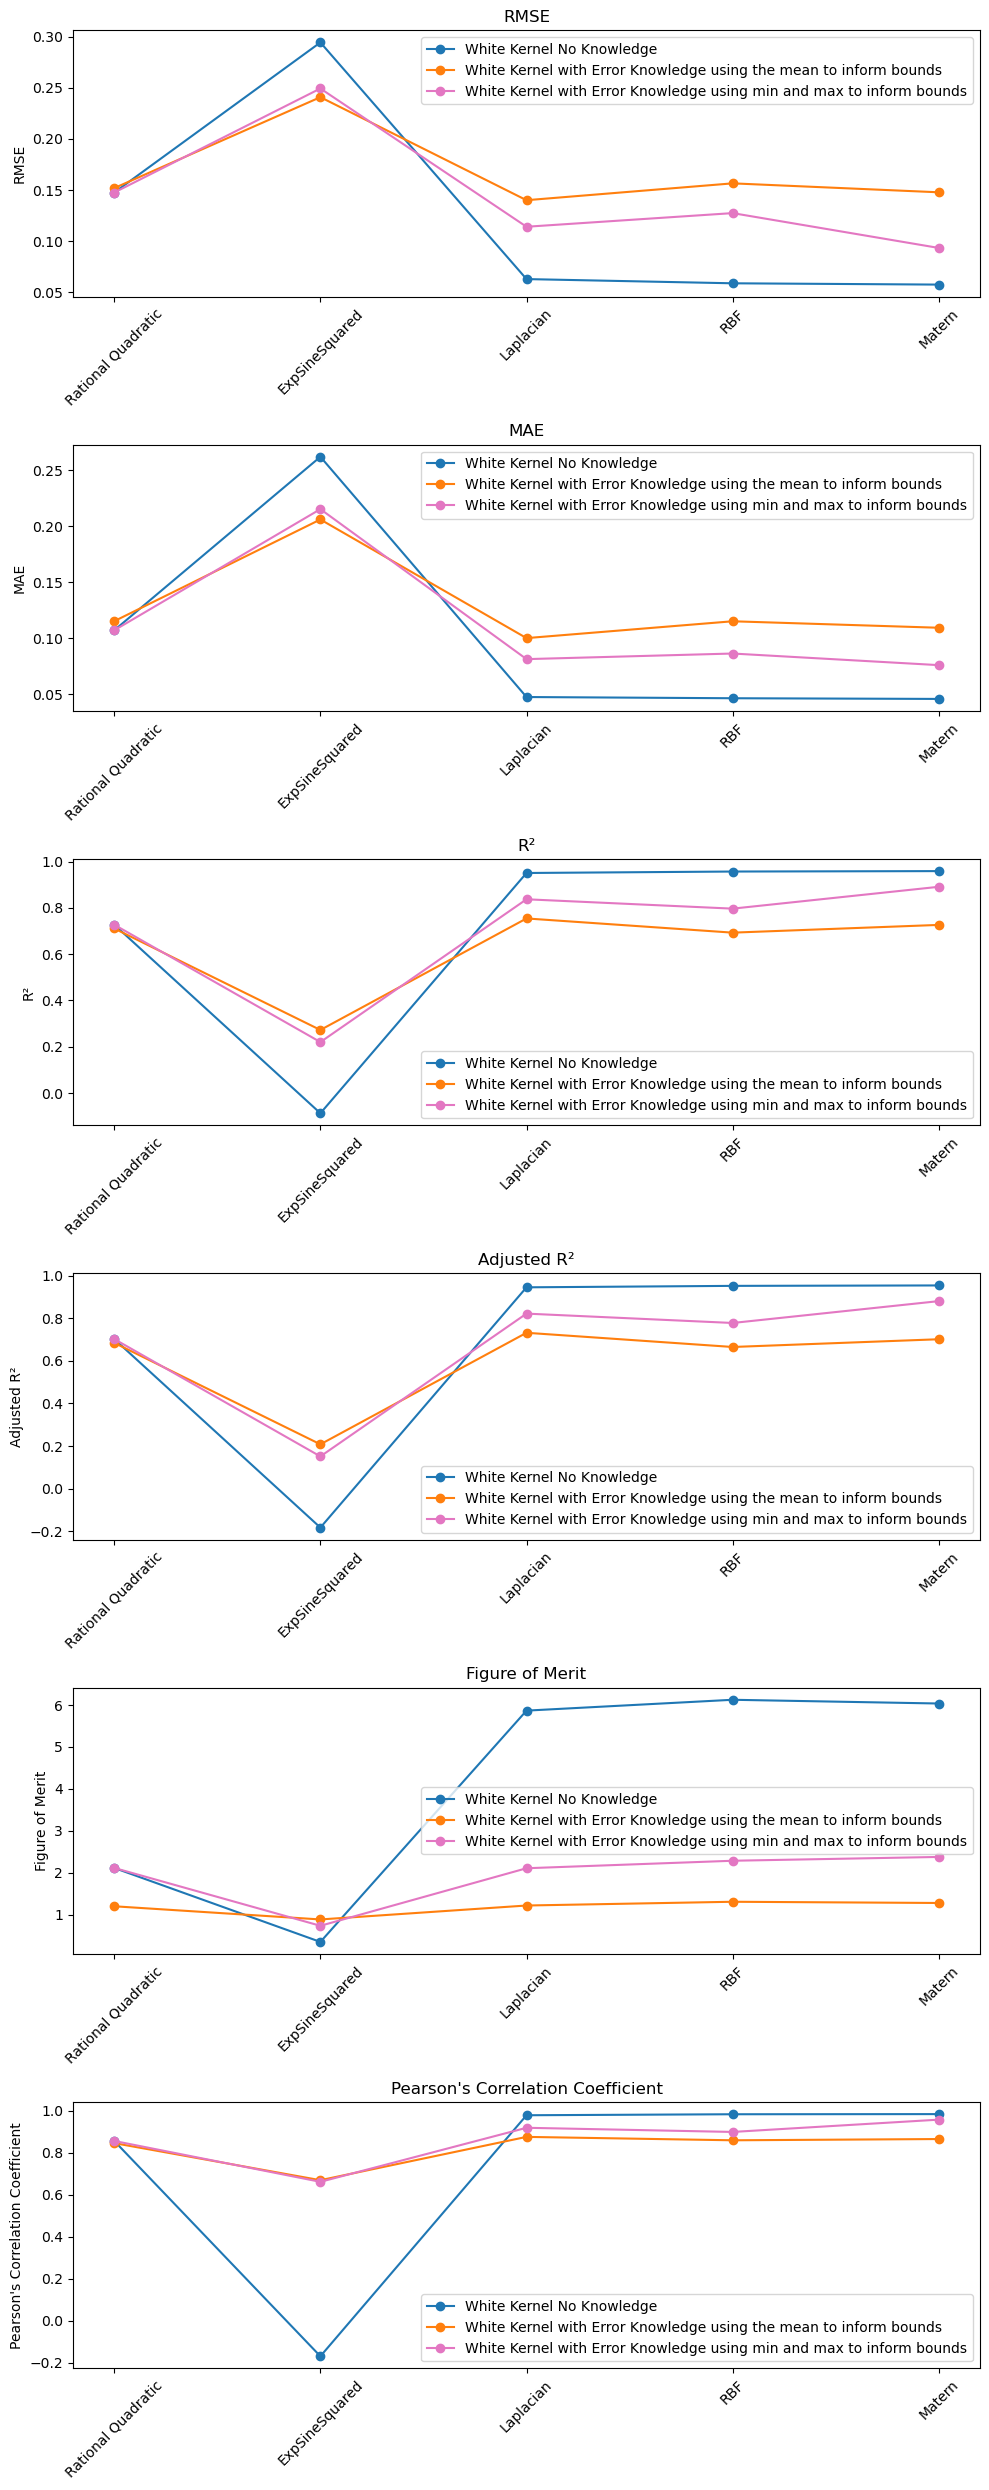

In [28]:
metrics = [rmse, mae, r2, adjustedr2, fom,pearsoncoeff]
metric_names = ["RMSE", "MAE", "R²", "Adjusted R²", "Figure of Merit","Pearson's Correlation Coefficient"]
fitlabels = ["White Kernel No Knowledge", "White Kernel with Error Knowledge using the mean to inform bounds","White Kernel with Error Knowledge using min and max to inform bounds"]

# Distinct colors for the fits (2 colors)
colors = ['#1f77b4', '#ff7f0e','#e377c2']

WhiteKernelNoKnowledgeMetrics = np.array(metrics)[:, :5]
WhiteKernelwitherrormean = np.array(metrics)[:, 5:10]
WhiteKernelwitherrorminmax = np.array(metrics)[:,10:]



fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,25))
for i in range(len(metric_names)):
    axes[i].plot(range(len(kernel_list)),WhiteKernelNoKnowledgeMetrics[i,:],'-o',label=fitlabels[0],color=colors[0])
    axes[i].plot(range(len(kernel_list)),WhiteKernelwitherrormean[i,:],'-o',label=fitlabels[1],color=colors[1])
    axes[i].plot(range(len(kernel_list)),WhiteKernelwitherrorminmax[i,:],'-o',label=fitlabels[2],color=colors[2])
    axes[i].legend(loc='best')
    axes[i].set_xticks(range(len(kernel_list)))
    axes[i].set_xticklabels(kernel_names, rotation=45)
    axes[i].set_title(metric_names[i])
    axes[i].set_ylabel(metric_names[i])


plt.tight_layout()
plt.show()

In [11]:
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\WhiteKernelNoKnowledgeMetrics.csv", WhiteKernelNoKnowledgeMetrics, delimiter=",")
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\WhiteKernelwitherrormean.csv", WhiteKernelwitherrormean, delimiter=",")
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\WhiteKernelwitherrorminmax.csv", WhiteKernelwitherrorminmax, delimiter=",")